In [1]:
from bs4 import BeautifulSoup
import requests as req
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')

In [2]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'}

In [3]:
# r = req.get(f'{url}&pgn={page}', headers=headers)
# soup = BeautifulSoup(r.text, 'html.parser')
# reviews = soup.findAll('div', {'class': 'ebay-review-section'})
# for review in reviews:
#     title = review.find('h3', {'class': 'review-item-title wrap-spaces'})
#     review1 = review.find('p', {'class': 'review-item-content rvw-wrap-spaces'})
#     review2 = review.find('span', {'class': 'show-full-review'})
    
    
#     stars = len(review.find_all('i', {'class': 'fullStar'}))
#     date = review.find('span', {'class': 'review-item-date'}).text    
#     print(date)

    
#     if review1 is None:
#             continue

#     if review2 is None:
#         text_review = review1.text
#     else:
#         text_review = review1.text + review2.text

#     print(text_review)
#     break

### Data Scraping

In [4]:
url = 'https://www.ebay.com/itm/PS5-Sony-PlayStation-5-Console-Disc-Version-/325389825157'
r = req.get(url, headers = headers)
this_soup = BeautifulSoup(r.text, 'html.parser')
reviews_url = this_soup.find('a', {'class': 'sar-btn right'})['href']
num_of_reviews = this_soup.find('a', {'class': 'sar-btn right'}).text

num_of_reviews = int(num_of_reviews.split()[2].replace(',', ''))
num_of_pages = int(num_of_reviews / 10)

if num_of_pages > 20:
    num_of_pages = 20

url = this_soup.find('a', {'class': 'sar-btn right'})['href']

data = []
for page in range(1, num_of_pages+1):
    r = req.get(f'{url}&pgn={page}', headers=headers)
    soup = BeautifulSoup(r.text, 'html.parser')
    reviews = soup.findAll('div', {'class': 'ebay-review-section'})
    for review in reviews:
        title = review.find('h3', {'class': 'review-item-title wrap-spaces'})
        review1 = review.find('p', {'class': 'review-item-content rvw-wrap-spaces'})
        review2 = review.find('span', {'class': 'show-full-review'})
        
        stars = len(review.find_all('i', {'class': 'fullStar'}))
        date = review.find('span', {'class': 'review-item-date'}).text    

        if review1 is None:
            continue

        if review2 is None:
            text_review = review1.text
        else:
            text_review = review1.text + review2.text

        this_title = title.text
        this_review = text_review

        d = {'title': this_title, 'review': this_review, 'star': stars, 'date': date}
        data.append(d)

In [5]:
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df.date, format = '%b %d, %Y')
df = df.set_index('date').sort_index()
df.tail()

,title,review,star
date,,,
2022-11-10,Advancement from previous ps consoles.,"Quiet operation, easy to initialize, operation...",5
2022-11-12,PS5 Pops,From the design of the PS5 to the dynamic cont...,5
2022-12-03,Worth it,Great system! The media apps could use some im...,5
2022-12-04,My PS5,"2 weeks before getting my PS5, my PS4 had give...",5
2023-01-04,Awesome gift. Hidden fees,I got this as a gift for my little brother for...,5


In [6]:
import nltk

In [7]:
titles = ' '.join(df.title)
reviews = ' '.join(df.review)

In [8]:
words = set(nltk.corpus.words.words())
reviews = " ".join(w for w in nltk.wordpunct_tokenize(reviews) if w.lower() in words or not w.isalpha())

In [9]:
stopwords = nltk.corpus.stopwords.words("english")
tokens = nltk.word_tokenize(reviews)

clear_words = [w.lower() for w in tokens if w.lower() not in stopwords]
clear_words = [w for w in clear_words if w.isalpha()]

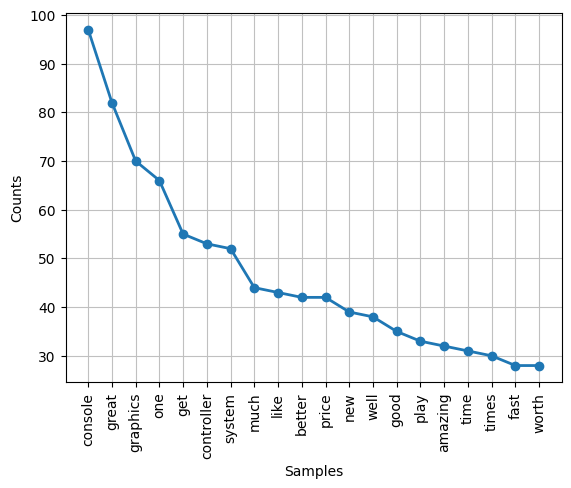

In [10]:
nlp_words=nltk.FreqDist(clear_words)
nlp_words.plot(20, marker = 'o');

In [18]:
# Convert FreqDist to pandas DataFrame
df = pd.DataFrame(list(nlp_words.items()), columns=["Token", "Frequency"]).sort_values('Frequency', ascending=False).head(10)
# Print DataFrame
print(df)

          Token  Frequency
120     console         97
56        great         82
44     graphics         70
67          one         66
99          get         55
7    controller         53
1        system         52
135        much         44
38         like         43
102      better         42


In [28]:
import plotly.express as px
df['Top Words'] = 'Top Words'
fig = px.treemap(df, path=['Top Words', 'Token'], values='Frequency')
fig.data[0].textinfo = 'label+value'
fig.show()

In [31]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [32]:
pos_words = [w for w in clear_words if sia.polarity_scores(w)['pos'] > 0.5]
neg_words = [w for w in clear_words if sia.polarity_scores(w)['neg'] > 0.5]

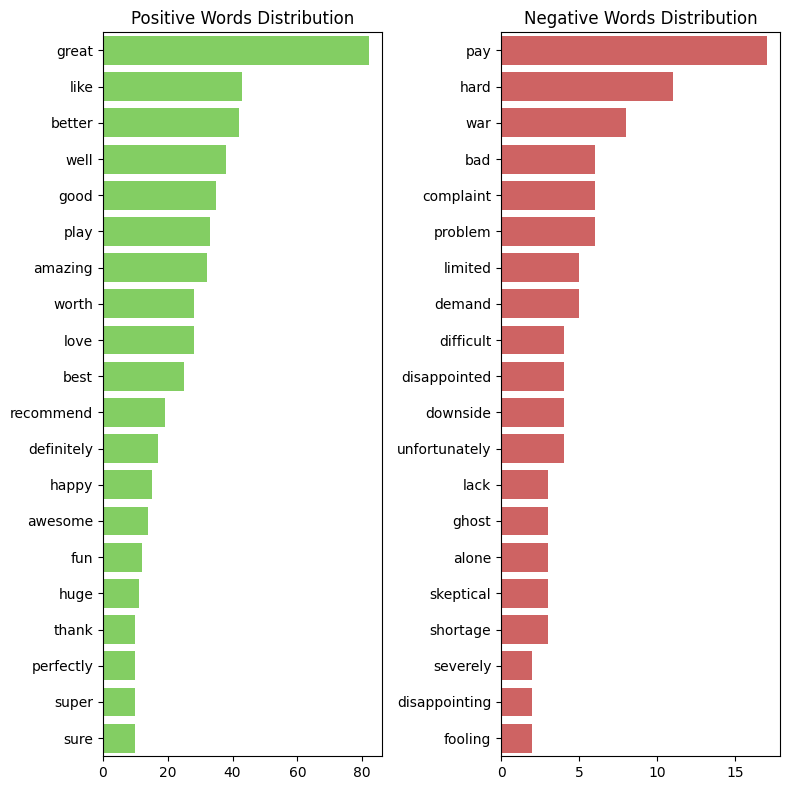

In [33]:
pos_words_freq=nltk.FreqDist(pos_words)
pos_words_freq = pd.Series(pos_words_freq).sort_values(ascending = False).head(20)

neg_words_freq=nltk.FreqDist(neg_words)
neg_words_freq = pd.Series(neg_words_freq).sort_values(ascending = False).head(20)

fig, axs = plt.subplots(1, 2, figsize = (8, 8))

sns.barplot(y = pos_words_freq.index, x=pos_words_freq.values, color = '#7ce051', ax = axs[0]);
sns.barplot(y = neg_words_freq.index, x=neg_words_freq.values, color = '#e05151', ax= axs[1]);

axs[0].set_title('Positive Words Distribution')
axs[1].set_title('Negative Words Distribution');
plt.tight_layout()

In [29]:
total = len(pos_words) + len(neg_words)
plt.pie([len(pos_words), len(neg_words)], labels = ['Positive Words', 'Negative Words'], autopct='%1.1f%%', colors = ['#7ce051', '#e05151']);
print(len(pos_words))
print(len(neg_words))

NameError: name 'pos_words' is not defined

### Sentiment Analysis

In [22]:
# import ssl
# import nltk
# import urllib.request

# # download the SSL certificate
# ssl._create_default_https_context = ssl._create_unverified_context
# url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml"
# urllib.request.urlopen(url)

# download the NLTK data
# nltk.download('punkt')


# import nltk
# nltk.download([
#   "names",
#   "stopwords",
#   "state_union",
#   "twitter_samples",
#   "movie_reviews",
#   "averaged_perceptron_tagger",
#   "vader_lexicon",
#   "words",
#   "punkt"])

[nltk_data] Downloading package names to
[nltk_data]     /Users/kevinfernando/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kevinfernando/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package state_union to
[nltk_data]     /Users/kevinfernando/nltk_data...
[nltk_data]   Unzipping corpora/state_union.zip.
[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/kevinfernando/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/kevinfernando/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kevinfernando/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kevinfernando/nltk_data...

True

In [26]:
all_reviews = ' '.join(df.review.values)

In [31]:
words = set(nltk.corpus.words.words())
reviews = " ".join(w for w in nltk.wordpunct_tokenize(reviews) if w.lower() in words or not w.isalpha())

TypeError: expected string or bytes-like object, got 'ResultSet'